In [9]:
import requests
from bs4 import BeautifulSoup

# Replace with the name/value from your browser exactly
COOKIE_NAME = "sid"
COOKIE_VALUE = "17f98ed892c219e814ccc434836ee213"

def fetch_component_materials(component_id: int):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Cookie": f"sid={COOKIE_VALUE}"  # replace key name if it's different
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # Extract materials from HTML structure
    materials = []
    for li in soup.select("#element-composite ol.sortable li .element-selector"):
        materials.append(li.text.strip())

    return materials

# Test it
component_id = 558048
materials = fetch_component_materials(component_id)
print(f"Component {component_id} materials:", materials)



Component 558048 materials: ['Kalk Innenputz', 'Kalksandstein', 'Dämmung - Abdichtung']


In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# 💡 1. Set your session cookie (grabbed from browser)
COOKIE_VALUE = "17f98ed892c219e814ccc434836ee213"

# 💡 2. Get UUID from a material's detail page
def get_material_uuid(material_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={material_id}&tab=general"
    headers = {"User-Agent": "Mozilla/5.0"}
    cookies = {"sid": COOKIE_VALUE}

    try:
        response = requests.get(url, headers=headers, cookies=cookies, timeout=10)
        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")
        uuid_elem = soup.find("span", class_="selection-value", string=lambda x: x and "-" in x)
        return uuid_elem.text.strip() if uuid_elem else None
    except Exception as e:
        print(f"UUID fetch failed for {material_id}: {e}")
        return None

# 💡 3. For each component, get its name and linked materials
def fetch_component_data(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    headers = {"User-Agent": "Mozilla/5.0"}
    cookies = {"sid": COOKIE_VALUE}

    try:
        response = requests.get(url, headers=headers, cookies=cookies, timeout=10)
        if response.status_code != 200:
            return []

        soup = BeautifulSoup(response.text, "html.parser")

        # Component name (e.g., "Außenwand / einschaliges Mauerwerk / erdberührt")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        materials_block = soup.select("#element-composite ol.sortable li")
        results = []

        for li in materials_block:
            name_tag = li.select_one(".element-selector")
            link_tag = li.select_one("a[href*='/elements/'][href*='tab=general']")

            if name_tag and link_tag:
                material_name = name_tag.text.strip()
                material_id = link_tag["href"].split("/")[2]  # e.g., /elements/558049/
                material_uuid = get_material_uuid(material_id)

                results.append({
                    "component_id": component_id,
                    "component_name": component_name,
                    "material_name": material_name,
                    "material_id": material_id,
                    "material_uuid": material_uuid
                })

        return results

    except Exception as e:
        print(f"❌ Component {component_id} failed: {e}")
        return []

# 💡 4. Loop over component IDs
all_data = []
start_id = 1900
end_id = 1910  # expand this when stable

for cid in range(start_id, end_id):
    materials_info = fetch_component_data(cid)
    if materials_info:
        all_data.extend(materials_info)
        print(f"✅ {cid} → {len(materials_info)} materials")
    else:
        print(f"— {cid} skipped")
    time.sleep(0.25)  # delay to avoid hammering the server

# 💡 5. Save results
df = pd.DataFrame(all_data)
df.to_csv("component_materials_with_uuids.csv", index=False)
print("📦 Saved to component_materials_with_uuids.csv")


— 1900 skipped
— 1901 skipped
— 1902 skipped
— 1903 skipped
— 1904 skipped
— 1905 skipped
— 1906 skipped
— 1907 skipped
✅ 1908 → 3 materials
— 1909 skipped
📦 Saved to component_materials_with_uuids.csv


## Script to Scrape Category Overview Page
Here's an example script to scrape all components from one category (e.g. 330 exterior walls, t=246)
The URL you're referring to is a client-side rendered (JavaScript) app (with a #!/ in the path), which means that the content (like the component list) is not available in the raw HTML of the page source fetched with requests. That’s why BeautifulSoup is returning an empty result. We will use selenium instead

In [11]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import re
import pandas as pd
import time

options = Options()
options.add_argument("--headless=new")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

service = Service("/usr/local/bin/chromedriver")
driver = webdriver.Chrome(service=service, options=options)

# STEP 1: Open stub page to enable cookie injection
driver.get("https://www.bauteileditor.de/favicon.ico")
time.sleep(1)

# STEP 2: Inject cookie
driver.add_cookie({
    'name': 'sid',
    'value': "17f98ed892c219e814ccc434836ee213",  # Your real SID
    'domain': 'www.bauteileditor.de',
    'path': '/',
})

# STEP 3: Now go to the real page
url = "https://www.bauteileditor.de/elements/list/?t=246"
driver.get(url)
time.sleep(5)

# STEP 4: Scroll and wait
for _ in range(3):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

# STEP 5: Extract components
elements = driver.find_elements(By.CSS_SELECTOR, "h2.headline.ref-element")

component_data = []
for el in elements:
    text = el.text.strip()
    match = re.search(r"(.*?)\s*\[(\d+)\]", text)
    if match:
        name = match.group(1).strip()
        comp_id = int(match.group(2))
        component_data.append({"id": comp_id, "name": name})

driver.quit()

# STEP 6: Output
df = pd.DataFrame(component_data)
# to csv
df.to_csv("components_list.csv", index=False)



In [12]:
df

,id,name
0,558048,Außenwand / einschaliges Mauerwerk / erdberührt
1,1908,Außenwand / einschaliges Mauerwerk / Innendämmung
2,450096,Außenwand / einschaliges Mauerwerk / Innendämmung
3,1955,Außenwand / einschaliges Mauerwerk / WDVS / In...
4,13612,Außenwand / einschaliges Mauerwerk / WDVS mit ...
5,450081,Außenwand / einschaliges Mauerwerk / WDVS mit ...
6,11547,Außenwand / einschaliges Mauerwerk / WDVS / ve...
7,43850,Außenwand Gaube / Holzrahmenbau / Schieferverk...
8,450092,Außenwand Gaube / Holzrahmenbau / Schieferverk...
9,556553,Außenwand / Holzmassivbau / Holzverkleidung


In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

# === Configuration ===
COOKIE_VALUE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": COOKIE_VALUE}

# ✅ 1. Get UUID from material detail page
def get_material_uuid(material_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={material_id}&tab=general"
    try:
        print(f"🔍 Fetching UUID for material ID {material_id}...")
        response = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        print(f"Status Code: {response.status_code}")
        if response.status_code != 200:
            return None
        soup = BeautifulSoup(response.text, "html.parser")
        uuid_elem = soup.find("span", class_="selection-value", string=lambda x: x and "-" in x)
        return uuid_elem.text.strip() if uuid_elem else None
    except Exception as e:
        print(f"UUID fetch failed for {material_id}: {e}")
        return None

# ✅ 2. Get materials for a component ID
def fetch_component_data(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        print(f"\n🧱 Fetching component ID {component_id}...")
        response = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        print(f"Component status code: {response.status_code}")
        if response.status_code != 200:
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None
        print(f"Component name: {component_name}")

        materials_block = soup.select("#element-composite ol.sortable li")
        results = []

        for li in materials_block:
            name_tag = li.select_one(".element-selector")
            link_tag = li.select_one("a[href*='/elements/'][href*='tab=general']")

            if name_tag and link_tag:
                material_name = name_tag.text.strip()
                material_id = link_tag["href"].split("/")[2]
                material_uuid = get_material_uuid(material_id)

                results.append({
                    "component_id": component_id,
                    "component_name": component_name,
                    "material_name": material_name,
                    "material_id": material_id,
                    "material_uuid": material_uuid
                })

        return results
    except Exception as e:
        print(f"❌ Component {component_id} failed: {e}")
        return []

# ✅ 3. Test with a single known-good ID
test_component_ids = [558048]  # Außenwand / einschaliges Mauerwerk / erdberührt

all_data = []
for cid in test_component_ids:
    materials_info = fetch_component_data(cid)
    if materials_info:
        all_data.extend(materials_info)
        print(f"✅ {cid} → {len(materials_info)} materials found.")
    else:
        print(f"— {cid} skipped or empty.")
    time.sleep(0.25)

# ✅ 4. Output results
df = pd.DataFrame(all_data)



🧱 Fetching component ID 558048...
Component status code: 200
Component name: Außenwand / einschaliges Mauerwerk / erdberührt
🔍 Fetching UUID for material ID 558049...
Status Code: 200
🔍 Fetching UUID for material ID 558050...
Status Code: 200
🔍 Fetching UUID for material ID 558051...
Status Code: 200
✅ 558048 → 3 materials found.


In [14]:
df

,component_id,component_name,material_name,material_id,material_uuid
0,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz,558049,987fd96c-daad-4f08-8e26-a1dfac76b505
1,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalksandstein,558050,71d49937-5585-4dea-ba1f-456dbb70e338
2,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Dämmung - Abdichtung,558051,95b680d4-7813-4c4b-8e36-666230a0f5f3


In [15]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

# === Configuration ===
COOKIE_VALUE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": COOKIE_VALUE}

# ✅ Load list of component IDs and names (from your Selenium scrape)
components_df = pd.read_csv("components_list.csv")
print(f"Loaded {len(components_df)} components.")

# ✅ 1. Get UUID from material detail page
def get_material_uuid(material_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={material_id}&tab=general"
    try:
        response = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")
        uuid_elem = soup.find("span", class_="selection-value", string=lambda x: x and "-" in x)
        return uuid_elem.text.strip() if uuid_elem else None
    except Exception as e:
        print(f"UUID fetch failed for {material_id}: {e}")
        return None

# ✅ 2. Get materials for a component ID
def fetch_component_data(component_id, component_name):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        response = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        if response.status_code != 200:
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        materials_block = soup.select("#element-composite ol.sortable li")
        results = []

        for li in materials_block:
            name_tag = li.select_one(".element-selector")
            link_tag = li.select_one("a[href*='/elements/'][href*='tab=general']")

            if name_tag and link_tag:
                material_name = name_tag.text.strip()
                material_id = link_tag["href"].split("/")[2]
                material_uuid = get_material_uuid(material_id)

                results.append({
                    "component_id": component_id,
                    "component_name": component_name,
                    "material_name": material_name,
                    "material_id": material_id,
                    "material_uuid": material_uuid
                })

        return results
    except Exception as e:
        print(f"❌ Component {component_id} failed: {e}")
        return []

# ✅ 3. Loop over all components
all_results = []

for idx, row in components_df.iterrows():
    cid = row["id"]
    cname = row["name"]
    print(f"🔄 Processing {cid} - {cname}")
    data = fetch_component_data(cid, cname)
    if data:
        all_results.extend(data)
        print(f"✅ Found {len(data)} materials.")
    else:
        print(f"— Skipped or empty.")
    time.sleep(0.3)

# ✅ 4. Save to CSV
df_final = pd.DataFrame(all_results)
df_final.to_csv("component_materials_with_uuids.csv", index=False)
print("🎉 Done! Data saved to component_materials_with_uuids.csv")  


Loaded 24 components.
🔄 Processing 558048 - Außenwand / einschaliges Mauerwerk / erdberührt
✅ Found 3 materials.
🔄 Processing 1908 - Außenwand / einschaliges Mauerwerk / Innendämmung
✅ Found 3 materials.
🔄 Processing 450096 - Außenwand / einschaliges Mauerwerk / Innendämmung
✅ Found 3 materials.
🔄 Processing 1955 - Außenwand / einschaliges Mauerwerk / WDVS / Innenfliesen
✅ Found 3 materials.
🔄 Processing 13612 - Außenwand / einschaliges Mauerwerk / WDVS mit Fenster
✅ Found 3 materials.
🔄 Processing 450081 - Außenwand / einschaliges Mauerwerk / WDVS mit Fenster
✅ Found 3 materials.
🔄 Processing 11547 - Außenwand / einschaliges Mauerwerk / WDVS / verputzt
✅ Found 3 materials.
🔄 Processing 43850 - Außenwand Gaube / Holzrahmenbau / Schieferverkleidung
✅ Found 3 materials.
🔄 Processing 450092 - Außenwand Gaube / Holzrahmenbau / Schieferverkleidung
✅ Found 3 materials.
🔄 Processing 556553 - Außenwand / Holzmassivbau / Holzverkleidung
✅ Found 3 materials.
🔄 Processing 558275 - Außenwand / Hol

In [16]:
df_final

,component_id,component_name,material_name,material_id,material_uuid
0,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz,558049,987fd96c-daad-4f08-8e26-a1dfac76b505
1,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalksandstein,558050,71d49937-5585-4dea-ba1f-456dbb70e338
2,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Dämmung - Abdichtung,558051,95b680d4-7813-4c4b-8e36-666230a0f5f3
3,1908,Außenwand / einschaliges Mauerwerk / Innendämmung,Porenbeton-Dämmplatte_25mm_geklebt_Kalkputz_E,3277,6398a647-6b33-4dec-b8e8-db63832bd85e
4,1908,Außenwand / einschaliges Mauerwerk / Innendämmung,Mauerziegel_270mm_E,1876,2da50076-2478-4b48-ab0c-ee00a1012be4
...,...,...,...,...,...
62,11302,Außenwand / zweischaliges Mauerwerk / Kerndämmung,Kalksandstein 24cm,1810,549291bf-6a21-4816-a3a1-a01a1889949b
63,11302,Außenwand / zweischaliges Mauerwerk / Kerndämmung,MW / Kerndämmung,11303,418d58f5-3112-4cf4-b179-9aba3efa6f37
64,450117,Außenwand / zweischaliges Mauerwerk / Kerndämmung,Gips-Putz/Anstrich,450118,8b676bc4-0747-4319-b64d-9a8008be4ad1
65,450117,Außenwand / zweischaliges Mauerwerk / Kerndämmung,Kalksandstein 24cm,450119,f05dd3e3-21c1-4e32-b352-f5d3a8fe2f64


In [17]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

# === Setup Selenium ===
options = Options()
options.add_argument("--headless=new")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
service = Service("/usr/local/bin/chromedriver")
driver = webdriver.Chrome(service=service, options=options)

# === Session cookie ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
driver.get("https://www.bauteileditor.de/favicon.ico")
time.sleep(1)
driver.add_cookie({
    'name': 'sid',
    'value': SESSION_COOKIE,
    'domain': 'www.bauteileditor.de',
    'path': '/',
})

# === HTTP settings for requests ===
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === Extract UUID from material detail page ===
def get_material_uuid(material_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={material_id}&tab=general"
    try:
        r = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")
        uuid_elem = soup.find("span", class_="selection-value", string=lambda x: x and "-" in x)
        return uuid_elem.text.strip() if uuid_elem else None
    except:
        return None

# === Fetch component's materials and UUIDs ===
def fetch_component_materials(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        r = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None
        materials_block = soup.select("#element-composite ol.sortable li")

        results = []
        for li in materials_block:
            name_tag = li.select_one(".element-selector")
            link_tag = li.select_one("a[href*='/elements/'][href*='tab=general']")
            if name_tag and link_tag:
                material_name = name_tag.text.strip()
                material_id = link_tag["href"].split("/")[2]
                material_uuid = get_material_uuid(material_id)
                results.append({
                    "component_id": component_id,
                    "component_name": component_name,
                    "material_name": material_name,
                    "material_id": material_id,
                    "material_uuid": material_uuid
                })
        return results
    except:
        return []

# === Main categories to loop over ===
main_categories = [237, 246, 256, 264]  # skipping 269 and 270 as per user

# === Scrape all components and their materials ===
all_data = []

for t in main_categories:
    print(f"\n🔄 Scraping main category t={t}")
    url = f"https://www.bauteileditor.de/elements/list/?t={t}"
    driver.get(url)
    time.sleep(5)

    # Scroll to load full page content
    for _ in range(3):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

    elements = driver.find_elements(By.CSS_SELECTOR, "h2.headline.ref-element")
    component_ids = []
    for el in elements:
        match = re.search(r"(.*?)\s*\[(\d+)\]", el.text.strip())
        if match:
            comp_id = int(match.group(2))
            component_ids.append(comp_id)

    print(f"✅ Found {len(component_ids)} components")

    for cid in component_ids:
        materials = fetch_component_materials(cid)
        if materials:
            all_data.extend(materials)
            print(f"   ✅ {cid}: {len(materials)} materials")
        else:
            print(f"   — {cid}: no materials or skipped")
        time.sleep(0.25)

driver.quit()

# Save and display
df_all = pd.DataFrame(all_data)
# df_all.to_csv("all_components_with_materials.csv", index=False)




🔄 Scraping main category t=237
✅ Found 12 components
   ✅ 11217: 2 materials
   ✅ 43836: 2 materials
   ✅ 450110: 2 materials
   ✅ 1124879: 2 materials
   ✅ 11218: 2 materials
   ✅ 11221: 2 materials
   ✅ 2780: 3 materials
   ✅ 450113: 3 materials
   ✅ 1124883: 3 materials
   ✅ 3632: 4 materials
   ✅ 450101: 3 materials
   ✅ 1124887: 3 materials

🔄 Scraping main category t=246
✅ Found 24 components
   ✅ 558048: 3 materials
   ✅ 1908: 3 materials
   ✅ 450096: 3 materials
   ✅ 1955: 3 materials
   ✅ 13612: 3 materials
   ✅ 450081: 3 materials
   ✅ 11547: 3 materials
   ✅ 43850: 3 materials
   ✅ 450092: 3 materials
   ✅ 556553: 3 materials
   ✅ 558275: 3 materials
   ✅ 11224: 3 materials
   ✅ 450088: 3 materials
   ✅ 11230: 3 materials
   ✅ 450529: 3 materials
   ✅ 558532: 2 materials
   ✅ 11234: 2 materials
   ✅ 11238: 2 materials
   ✅ 11318: 2 materials
   ✅ 450509: 2 materials
   ✅ 11243: 3 materials
   ✅ 450503: 3 materials
   ✅ 11302: 3 materials
   ✅ 450117: 3 materials

🔄 Scraping

In [18]:
df_all

,component_id,component_name,material_name,material_id,material_uuid
0,11217,Bodenplatte / oberseitig gedämmt / Estrich / L...,oberseitige Dämmung / Estrich / Linolium,11216,6abf6a5a-73bb-40ba-877f-40d912e72c03
1,11217,Bodenplatte / oberseitig gedämmt / Estrich / L...,Fundamentplatte Stb. / Dränschicht,11211,1d5c3920-94c8-4b1f-ac78-50462ad483ba
2,43836,Bodenplatte / oberseitig gedämmt / Sand / schw...,G_Voranstrich_Kunstharz_5mm,43837,f9d4dfc9-7e91-4625-9963-a1cd732024e6
3,43836,Bodenplatte / oberseitig gedämmt / Sand / schw...,G_Bodenplatte_Stahlbeton-Ortbauweise_C25/30_25...,43844,20a90bce-17e1-40f8-9a22-db8adb923e29
4,450110,Bodenplatte / oberseitig gedämmt / Sand / schw...,G_Voranstrich_Kunstharz_5mm,450111,12306b63-5e9d-403a-9357-ffd80eeb960d
...,...,...,...,...,...
168,497538,Kellerdecke / Stb. / unterseitig gedämmt / sch...,IBO_GDm_01,497540,6a716ece-8aff-4b9e-91d5-f790db667192
169,497538,Kellerdecke / Stb. / unterseitig gedämmt / sch...,IBO_KDb_01,497541,4d1dc398-8995-475e-bc60-a554b1256a65
170,4644674,Kellerdecke / Stb. / unterseitig gedämmt / sch...,IBO_KDb_01,4644675,ed35c313-0396-49c5-940e-7aefa3dd5175
171,4644674,Kellerdecke / Stb. / unterseitig gedämmt / sch...,IBO_GDm_01,4644676,bb2ae572-4151-40e3-9a25-651edd124e27


In [22]:
obd_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/obd_merged.csv", sep=";")

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_49175/1856078198.py:1: DtypeWarning: Columns (13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  obd_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/obd_merged.csv", sep=";")


In [24]:
# find UUID
obd_df[obd_df["UUID"] == "ee10b277-07b5-4c0a-8a48-e0412a9630ff"]


,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
25109,ee10b277-07b5-4c0a-8a48-e0412a9630ff,00.07.000,EPS-Hartschaum (Styropor ®) für Decken/Böden u...,NaN,'Dämmstoffe' / 'Expandiertes Polystyrol (EPS)'...,'Insulation materials' / 'Expanded polystyrene...,'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25137,ee10b277-07b5-4c0a-8a48-e0412a9630ff,00.07.000,EPS-Hartschaum (Styropor ®) für Decken/Böden u...,NaN,'Dämmstoffe' / 'Expandiertes Polystyrol (EPS)'...,'Insulation materials' / 'Expanded polystyrene...,'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25138,ee10b277-07b5-4c0a-8a48-e0412a9630ff,00.07.000,EPS-Hartschaum (Styropor ®) für Decken/Böden u...,NaN,'Dämmstoffe' / 'Expandiertes Polystyrol (EPS)'...,'Insulation materials' / 'Expanded polystyrene...,'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25139,ee10b277-07b5-4c0a-8a48-e0412a9630ff,00.07.000,EPS-Hartschaum (Styropor ®) für Decken/Böden u...,NaN,'Dämmstoffe' / 'Expandiertes Polystyrol (EPS)'...,'Insulation materials' / 'Expanded polystyrene...,'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


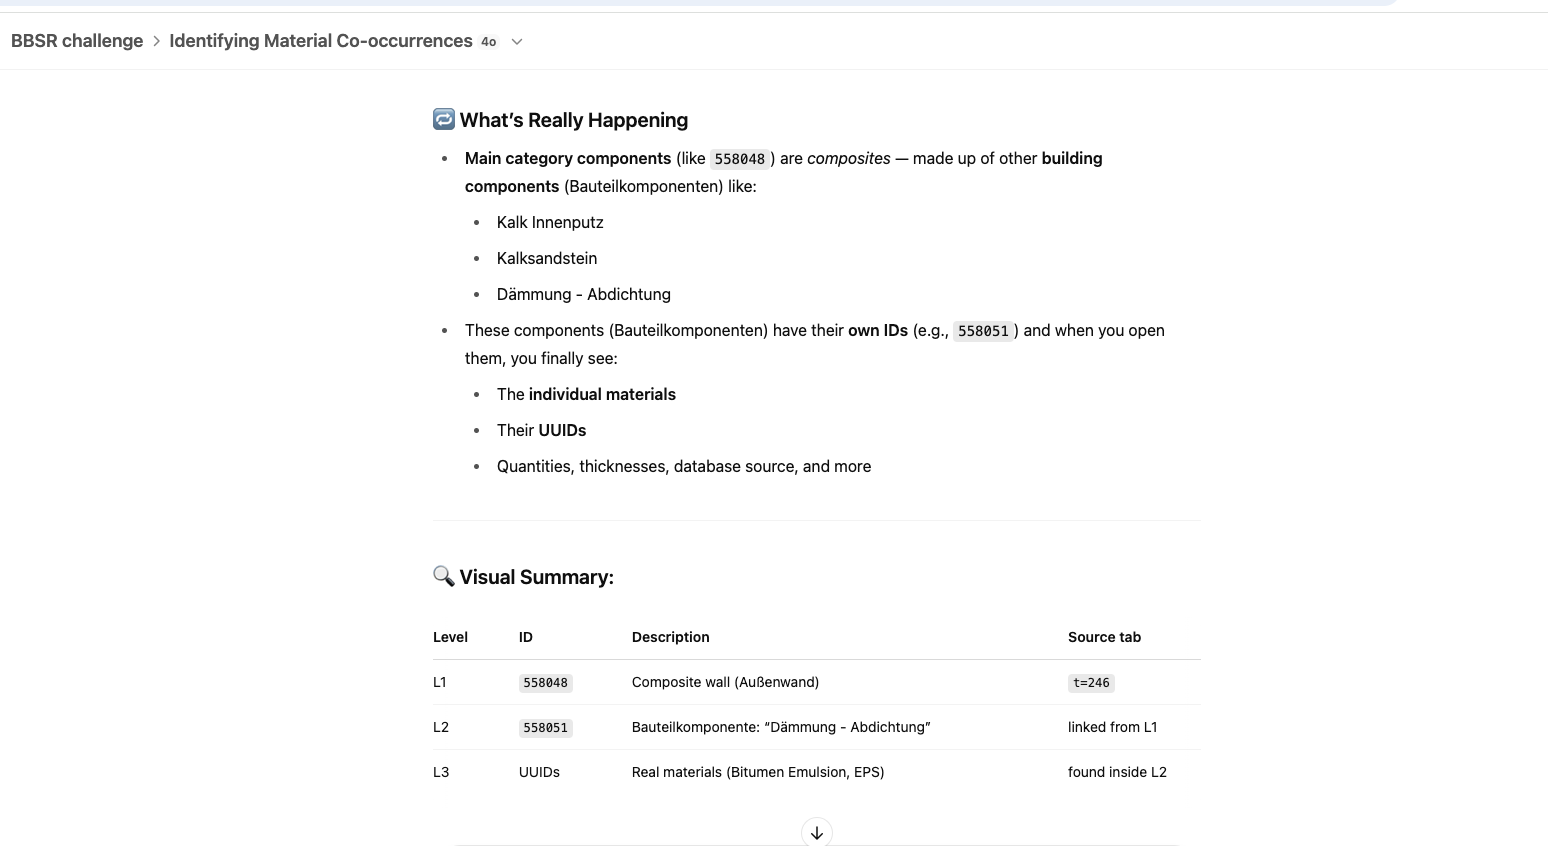

In [ ]:
# Re-import necessary modules after environment reset
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

# === Session Cookie and Headers for Requests ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === Get L2 Material Data with UUIDs ===
def get_l2_materials_layers(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        print(f"🔍 URL: {res.url} | Status: {res.status_code}")
        soup = BeautifulSoup(res.text, "html.parser")
        materials = []

        # Each material block
        layers = soup.select("ol.sortable li.sortable-item")
        for layer in layers:
            # Material name
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None

            # Thickness
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None

            # UUID table
            rows = layer.select("table.process-databases tr")
            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })
        return materials
    except Exception as e:
        print(f"Error in {component_id}: {e}")
        return []


# === Get Linked Subcomponent IDs from a composite component (L1) ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("#element-composite ol.sortable li a[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked if '/elements/' in a['href']]
        return component_name, sub_ids
    except Exception as e:
        return None, []

# === Load sample list of component IDs for demonstration ===
# Replace this with your real list when running locally
sample_component_ids = [558048, 558049, 558050, 558051]

all_data = []
for comp_id in sample_component_ids:
    l1_name, sub_ids = get_l1_subcomponents(comp_id)
    if not sub_ids:
        continue
    for sub_id in sub_ids:
        materials = get_l2_materials_layers(sub_id)
        for mat in materials:
            mat["component_id"] = comp_id
            mat["component_name"] = l1_name
            all_data.append(mat)
        time.sleep(0.25)

# Convert to DataFrame and display
df = pd.DataFrame(all_data)


🔍 URL: https://www.bauteileditor.de/elements/general/?e=toggleElement&tab=general | Status: 200
🔍 URL: https://www.bauteileditor.de/elements/general/?e=558049&tab=general | Status: 200
🔍 URL: https://www.bauteileditor.de/elements/general/?e=toggleElement&tab=general | Status: 200
🔍 URL: https://www.bauteileditor.de/elements/general/?e=558050&tab=general | Status: 200
🔍 URL: https://www.bauteileditor.de/elements/general/?e=toggleElement&tab=general | Status: 200
🔍 URL: https://www.bauteileditor.de/elements/general/?e=558051&tab=general | Status: 200


In [102]:
df

""


In [118]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

# === 0. Setup Selenium === 

options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===

SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        with open(f"debug_{component_id}.html", "w", encoding="utf-8") as f:
            f.write(soup.prettify())


        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        # Matches links like /elements/558049/?rel=558048&tab=general
        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked if '/elements/' in a['href']]

        return component_name, sub_ids
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, []

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        # Base load to allow cookie injection
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        cookies_to_set = [
            {'name': 'sid',"value": SESSION_COOKIE},
            {"name": "elca.elementsNavToggle.0", "value": "true"},
            {"name": "elca.elementsNavToggle.1", "value": "false"},
            {"name": "elca.elementsNavToggle.2", "value": "false"},
        ]
        for cookie in cookies_to_set:
            cookie['domain'] = 'www.bauteileditor.de'
            cookie ['path'] = '/'
            driver.add_cookie(cookie)

        # Navigate to the component page
        driver.get(url)
        driver.save_screenshot("logged_in_check.png")


        # Try to wait for material layers to load
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.element-component.layers"))
            )
        except TimeoutException:
            print(f"🕒 Timeout waiting for material layers in {component_id}")
            with open(f"timeout_{component_id}.html", "w", encoding="utf-8") as f:
                f.write(driver.page_source)
            return []
        
        # Click all expand toggles for materials
        expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen'], a.toggle-link[title='Werte verbergen']")
        for link in expand_links:
            try:
                driver.execute_script("arguments[0].click();", link)
                time.sleep(0.5)  # give it a moment to expand
            except Exception as e:
                print(f"⚠️ Failed to click toggle: {e}")


        soup = BeautifulSoup(driver.page_source, "html.parser")
        with open(f"debug_{component_id}.html", "w", encoding="utf-8") as f:
            f.write(soup.prettify())

        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None

            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None

            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")

            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} UUID rows found")

            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)

                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []

    for main_id in main_component_ids:
        l1_name, sub_ids = get_l1_subcomponents(main_id)
        if not sub_ids:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"🔗 Main {main_id} → {len(sub_ids)} subcomponents")

        for sub_id in sub_ids:
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue

            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                all_data.append(mat)

            time.sleep(0.25)

    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [558048]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)

# === 6. Save to CSV ===
# df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
# print("✅ Saved to all_uuid_materials_from_components.csv")


🔗 Main 558048 → 3 subcomponents
⚠️ Failed to click toggle: Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=135.0.7049.96); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
0   chromedriver                        0x000000010a6b4448 chromedriver + 6149192
1   chromedriver                        0x000000010a6abb0a chromedriver + 6114058
2   chromedriver                        0x000000010a13ce80 chromedriver + 417408
3   chromedriver                        0x000000010a143b8c chromedriver + 445324
4   chromedriver                        0x000000010a146897 chromedriver + 456855
5   chromedriver                        0x000000010a1dcb33 chromedriver + 1071923
6   chromedriver                        0x000000010a1b4792 chromedriver + 907154
7   chromedriver                        0x000000010a1dbaca chromedriver + 1067722
8   c

In [119]:
df_all

,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name
0,Kalk-Innenputz,5,Ökobau.dat 2009,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
1,Kalk-Innenputz,5,Ökobau.dat 2011,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
2,Kalk-Innenputz,5,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
3,Kalk-Innenputz,5,OBD_2020_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
4,Kalk-Innenputz,5,OBD_2021_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
5,Kalk-Innenputz,5,Ökobilanzierung-Rechenwerte 2023 V1.3,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
6,Kalk-Innenputz,5,OBD_2023_I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
7,Kalk-Innenputz,5,OBD_2023_I_A2,A1 - A3 Aggregation,Kalk-Innenputz,e0fdab1d-684b-44a5-8453-ef0f887addab,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
8,Kalk-Innenputz,5,OBD_2024_A2,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
9,Kalk-Innenputz,5,ÖBD_2024_A2_RMI,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt


In [105]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Setup
options = Options()
options.add_argument("--headless=new")
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# Use the function
for sub_id in [558049, 558050, 558051]:
    mats = get_l2_materials_layers_selenium(sub_id)
    print(f"{sub_id}: {len(mats)} materials")

# driver.quit()

🕒 Timeout waiting for material layers in 558049
558049: 0 materials
🕒 Timeout waiting for material layers in 558050
558050: 0 materials
🕒 Timeout waiting for material layers in 558051
558051: 0 materials


In [126]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked if '/elements/' in a['href']]

        return component_name, sub_ids
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, []

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        cookies_to_set = [
            {'name': 'sid', "value": SESSION_COOKIE},
            {"name": "elca.elementsNavToggle.0", "value": "true"},
            {"name": "elca.elementsNavToggle.1", "value": "false"},
            {"name": "elca.elementsNavToggle.2", "value": "false"},
        ]
        for cookie in cookies_to_set:
            cookie['domain'] = 'www.bauteileditor.de'
            cookie['path'] = '/'
            driver.add_cookie(cookie)

        driver.get(url)
        time.sleep(2)

        expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen'], a.toggle-link[title='Werte verbergen']")
        print(f"🔄 {len(expand_links)} collapsed layers to expand")
        for i, link in enumerate(expand_links):
            try:
                driver.execute_script("arguments[0].click();", link)
                WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "table.process-databases"))
                )
                print(f"   ✅ Expanded toggle {i+1}/{len(expand_links)}")
            except Exception as e:
                print(f"⚠️ Failed to click toggle: {e}")

        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None
            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")
            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} rows found")

            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_ids = get_l1_subcomponents(main_id)
        if not sub_ids:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_ids)} subcomponents")

        for sub_id in sub_ids:
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [558048]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 558048 → 3 subcomponents
🔄 0 collapsed layers to expand
🔍 Component 558049 → 0 material blocks
   — No materials in subcomponent 558049
🔄 2 collapsed layers to expand
   ✅ Expanded toggle 1/2
⚠️ Failed to click toggle: Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=135.0.7049.96); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
0   chromedriver                        0x0000000100d1f448 chromedriver + 6149192
1   chromedriver                        0x0000000100d16b0a chromedriver + 6114058
2   chromedriver                        0x00000001007a7e80 chromedriver + 417408
3   chromedriver                        0x00000001007aeb8c chromedriver + 445324
4   chromedriver                        0x00000001007b1897 chromedriver + 456855
5   chromedriver                        0x0000000100847b33 chromedriver + 1071923


In [127]:
df_all

,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name
0,Kalksandstein Mix,240,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Kalksandstein Mix,29e6c6cf-0552-4e4b-85c7-26a68a625252,558050,558048,Außenwand / einschaliges Mauerwerk / erdberührt
1,Kalksandstein Mix,240,OBD_2020_II_A1,A1 - A3 Aggregation,Kalksandstein Mix,29e6c6cf-0552-4e4b-85c7-26a68a625252,558050,558048,Außenwand / einschaliges Mauerwerk / erdberührt
2,Kalksandstein Mix,240,OBD_2021_II_A1,A1 - A3 Aggregation,Kalksandstein Mix,29e6c6cf-0552-4e4b-85c7-26a68a625252,558050,558048,Außenwand / einschaliges Mauerwerk / erdberührt
3,Kalksandstein Mix,240,Ökobilanzierung-Rechenwerte 2023 V1.3,A1 - A3 Aggregation,Kalksandstein Mix,29e6c6cf-0552-4e4b-85c7-26a68a625252,558050,558048,Außenwand / einschaliges Mauerwerk / erdberührt
4,Kalksandstein Mix,240,OBD_2023_I_A1,A1 - A3 Aggregation,Kalksandstein Mix,29e6c6cf-0552-4e4b-85c7-26a68a625252,558050,558048,Außenwand / einschaliges Mauerwerk / erdberührt
5,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",2,Ökobau.dat 2009,Herstellung,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",39c1f6e8-ff61-4d08-91f5-38c04dfcc1e3,558051,558048,Außenwand / einschaliges Mauerwerk / erdberührt
6,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",2,Ökobau.dat 2011,Herstellung,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",39c1f6e8-ff61-4d08-91f5-38c04dfcc1e3,558051,558048,Außenwand / einschaliges Mauerwerk / erdberührt
7,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",2,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",a6b26cf9-3f9a-4abc-9412-87fdc0cdf3f6,558051,558048,Außenwand / einschaliges Mauerwerk / erdberührt
8,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",2,OBD_2020_II_A1,A1 - A3 Aggregation,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",a6b26cf9-3f9a-4abc-9412-87fdc0cdf3f6,558051,558048,Außenwand / einschaliges Mauerwerk / erdberührt
9,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",2,OBD_2021_II_A1,A1 - A3 Aggregation,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",a6b26cf9-3f9a-4abc-9412-87fdc0cdf3f6,558051,558048,Außenwand / einschaliges Mauerwerk / erdberührt


In [128]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked if '/elements/' in a['href']]

        return component_name, sub_ids
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, []

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        cookies_to_set = [
            {'name': 'sid', "value": SESSION_COOKIE},
            {"name": "elca.elementsNavToggle.0", "value": "true"},
            {"name": "elca.elementsNavToggle.1", "value": "false"},
            {"name": "elca.elementsNavToggle.2", "value": "false"},
        ]
        for cookie in cookies_to_set:
            cookie['domain'] = 'www.bauteileditor.de'
            cookie['path'] = '/'
            driver.add_cookie(cookie)

        driver.get(url)
        time.sleep(2)

        expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen'], a.toggle-link[title='Werte verbergen']")
        print(f"🔄 {len(expand_links)} collapsed layers to expand")
        for i, link in enumerate(expand_links):
            try:
                driver.execute_script("arguments[0].scrollIntoView(true);", link)
                time.sleep(0.2)
                driver.execute_script("arguments[0].click();", link)
                WebDriverWait(driver, 2).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "table.process-databases"))
                )
                print(f"   ✅ Expanded toggle {i+1}/{len(expand_links)}")
            except StaleElementReferenceException:
                print(f"⚠️ Toggle {i+1} skipped due to StaleElementReference")
            except Exception as e:
                print(f"⚠️ Failed to click toggle: {e}")

        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None
            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")
            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} rows found")

            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_ids = get_l1_subcomponents(main_id)
        if not sub_ids:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_ids)} subcomponents")

        for sub_id in sub_ids:
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [558048]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 558048 → 3 subcomponents
🔄 2 collapsed layers to expand
   ✅ Expanded toggle 1/2
⚠️ Toggle 2 skipped due to StaleElementReference
🔍 Component 558049 → 1 material blocks
  📦 Layer 1: Kalk-Innenputz | Thickness: 5
    🧾 11 rows found
   ✅ Subcomponent 558049: 10 materials
🔄 2 collapsed layers to expand
   ✅ Expanded toggle 1/2
   ✅ Expanded toggle 2/2
🔍 Component 558050 → 1 material blocks
  📦 Layer 1: Kalksandstein Mix | Thickness: 240
    🧾 6 rows found
   ✅ Subcomponent 558050: 5 materials
🔄 4 collapsed layers to expand
   ✅ Expanded toggle 1/4
   ✅ Expanded toggle 2/4
   ✅ Expanded toggle 3/4
   ✅ Expanded toggle 4/4
🔍 Component 558051 → 2 material blocks
  📦 Layer 1: Bitumen Emulsion (40% Bitumen, 60% Wasser) | Thickness: 2
    🧾 11 rows found
  📦 Layer 2: EPS-Hartschaum (Styropor ®) für Decken/Böden und als Perimeterdämmung B/P-035 | Thickness: 140
    🧾 0 rows found
   ✅ Subcomponent 558051: 10 materials

✅ Saved to all_uuid_materials_from_components.csv


In [130]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked if '/elements/' in a['href']]

        return component_name, sub_ids
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, []

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        cookies_to_set = [
            {'name': 'sid', "value": SESSION_COOKIE},
            {"name": "elca.elementsNavToggle.0", "value": "true"},
            {"name": "elca.elementsNavToggle.1", "value": "false"},
            {"name": "elca.elementsNavToggle.2", "value": "false"},
        ]
        for cookie in cookies_to_set:
            cookie['domain'] = 'www.bauteileditor.de'
            cookie['path'] = '/'
            driver.add_cookie(cookie)

        driver.get(url)
        time.sleep(2)

        expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen'], a.toggle-link[title='Werte verbergen']")
        print(f"🔄 {len(expand_links)} collapsed layers to expand")

        for i in range(len(expand_links)):
            try:
                expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen'], a.toggle-link[title='Werte verbergen']")
                driver.execute_script("arguments[0].scrollIntoView(true);", expand_links[i])
                time.sleep(0.2)
                driver.execute_script("arguments[0].click();", expand_links[i])
                WebDriverWait(driver, 2).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "table.process-databases"))
                )
                print(f"   ✅ Expanded toggle {i+1}/{len(expand_links)}")
            except StaleElementReferenceException:
                print(f"⚠️ Toggle {i+1} skipped due to StaleElementReference")
            except Exception as e:
                print(f"⚠️ Failed to click toggle: {e}")

        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None
            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")
            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} rows found")

            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_ids = get_l1_subcomponents(main_id)
        if not sub_ids:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_ids)} subcomponents")

        for sub_id in sub_ids:
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [558048]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 558048 → 3 subcomponents
🔄 2 collapsed layers to expand
   ✅ Expanded toggle 1/2
   ✅ Expanded toggle 2/2
🔍 Component 558049 → 1 material blocks
  📦 Layer 1: Kalk-Innenputz | Thickness: 5
    🧾 11 rows found
   ✅ Subcomponent 558049: 10 materials
🔄 2 collapsed layers to expand
   ✅ Expanded toggle 1/2
   ✅ Expanded toggle 2/2
🔍 Component 558050 → 1 material blocks
  📦 Layer 1: Kalksandstein Mix | Thickness: 240
    🧾 6 rows found
   ✅ Subcomponent 558050: 5 materials
🔄 4 collapsed layers to expand
   ✅ Expanded toggle 1/4
   ✅ Expanded toggle 2/4
   ✅ Expanded toggle 3/4
   ✅ Expanded toggle 4/4
🔍 Component 558051 → 2 material blocks
  📦 Layer 1: Bitumen Emulsion (40% Bitumen, 60% Wasser) | Thickness: 2
    🧾 11 rows found
  📦 Layer 2: EPS-Hartschaum (Styropor ®) für Decken/Böden und als Perimeterdämmung B/P-035 | Thickness: 140
    🧾 4 rows found
   ✅ Subcomponent 558051: 13 materials

✅ Saved to all_uuid_materials_from_components.csv


In [131]:
df_all

,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name
0,Kalk-Innenputz,5,Ökobau.dat 2009,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
1,Kalk-Innenputz,5,Ökobau.dat 2011,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
2,Kalk-Innenputz,5,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
3,Kalk-Innenputz,5,OBD_2020_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
4,Kalk-Innenputz,5,OBD_2021_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
5,Kalk-Innenputz,5,Ökobilanzierung-Rechenwerte 2023 V1.3,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
6,Kalk-Innenputz,5,OBD_2023_I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
7,Kalk-Innenputz,5,OBD_2023_I_A2,A1 - A3 Aggregation,Kalk-Innenputz,e0fdab1d-684b-44a5-8453-ef0f887addab,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
8,Kalk-Innenputz,5,OBD_2024_A2,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt
9,Kalk-Innenputz,5,ÖBD_2024_A2_RMI,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt


In [135]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs and names from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked]
        sub_names = [a.text.strip() for a in linked]

        sub_map = dict(zip(sub_ids, sub_names))
        return component_name, sub_map
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, {}

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        driver.add_cookie({
            'name': 'sid',
            'value': SESSION_COOKIE,
            'domain': 'www.bauteileditor.de',
            'path': '/',
        })
        driver.get(url)
        time.sleep(4)

        # Expand material layers before parsing
        expand_links = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen']")
        for i, link in enumerate(expand_links):
            try:
                driver.execute_script("arguments[0].scrollIntoView(true);", link)
                time.sleep(0.2)
                driver.execute_script("arguments[0].click();", link)
                print(f"   ✅ Expanded toggle {i+1}/{len(expand_links)}")
                time.sleep(0.5)
            except Exception as e:
                print(f"⚠️ Toggle {i+1} failed: {e}")


        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None
            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")

            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} rows found")

            for row in rows[1:]:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_map = get_l1_subcomponents(main_id)
        if not sub_map:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_map)} subcomponents")

        for sub_id, sub_name in sub_map.items():
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                mat["subcomponent_name"] = sub_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [558048]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 558048 → 3 subcomponents
   ✅ Expanded toggle 1/2
⚠️ Toggle 2 failed: Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=135.0.7049.96); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
0   chromedriver                        0x00000001034a3448 chromedriver + 6149192
1   chromedriver                        0x000000010349ab0a chromedriver + 6114058
2   chromedriver                        0x0000000102f2be80 chromedriver + 417408
3   chromedriver                        0x0000000102f32b8c chromedriver + 445324
4   chromedriver                        0x0000000102f35897 chromedriver + 456855
5   chromedriver                        0x0000000102fcbb33 chromedriver + 1071923
6   chromedriver                        0x0000000102fa3792 chromedriver + 907154
7   chromedriver                        0x0000000102fcaaca chromedri

In [136]:
df_all

,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name,subcomponent_name
0,Kalk-Innenputz,5,Ökobau.dat 2009,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
1,Kalk-Innenputz,5,Ökobau.dat 2011,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
2,Kalk-Innenputz,5,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
3,Kalk-Innenputz,5,OBD_2020_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
4,Kalk-Innenputz,5,OBD_2021_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
5,Kalk-Innenputz,5,Ökobilanzierung-Rechenwerte 2023 V1.3,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
6,Kalk-Innenputz,5,OBD_2023_I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
7,Kalk-Innenputz,5,OBD_2023_I_A2,A1 - A3 Aggregation,Kalk-Innenputz,e0fdab1d-684b-44a5-8453-ef0f887addab,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
8,Kalk-Innenputz,5,OBD_2024_A2,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen
9,Kalk-Innenputz,5,ÖBD_2024_A2_RMI,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Ansehen


In [154]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)  # Keeps Chrome open after script
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs and names from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        res = requests.get(url, headers=HEADERS, cookies=COOKIES, timeout=10)
        soup = BeautifulSoup(res.text, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked]

        # Now get subcomponent names from their surrounding divs
        labels = soup.select("div.element .element-selector")
        sub_names = [label.get_text(strip=True) for label in labels]

        sub_map = dict(zip(sub_ids, sub_names))
        return component_name, sub_map
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, {}

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        driver.add_cookie({
            'name': 'sid',
            'value': SESSION_COOKIE,
            'domain': 'www.bauteileditor.de',
            'path': '/',
        })
        driver.get(url)
        time.sleep(4)

        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None
            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")

            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)} rows found")

            for row in rows[1:]:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_map = get_l1_subcomponents(main_id)
        if not sub_map:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_map)} subcomponents")

        for sub_id, sub_name in sub_map.items():
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                mat["subcomponent_name"] = sub_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)

# === 5. Run It ===
main_component_ids = [450096]  # 👈 You can expand this to more composites
df_all = extract_all_materials_from_main_components(main_component_ids)
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 450096 → 3 subcomponents
🔍 Component 450097 → 3 material blocks
  📦 Layer 1: Kalk-Innenputz | Thickness: 10
    🧾 0 rows found
  📦 Layer 2: Multipor Mineraldämmplatte | Thickness: 25
    🧾 0 rows found
  📦 Layer 3: Kleber für Gipsplatten | Thickness: 1
    🧾 0 rows found
   — No materials in subcomponent 450097
🔍 Component 450098 → 1 material blocks
  📦 Layer 1: Mauerziegel | Thickness: 270
    🧾 5 rows found
   ✅ Subcomponent 450098: 4 materials
🔍 Component 450099 → 2 material blocks
  📦 Layer 1: Fassadenfarbe Silikat-Dispersionsfarbe | Thickness: 0,1
    🧾 11 rows found
  📦 Layer 2: Fassadenfarbe Silikat-Dispersionsfarbe | Thickness: 0,2
    🧾 11 rows found
   ✅ Subcomponent 450099: 20 materials

✅ Saved to all_uuid_materials_from_components.csv


In [147]:
df_all

,material_name,thickness_mm,database,life_cycle,process,uuid,subcomponent_id,main_component_id,main_component_name,subcomponent_name
0,Kalk-Innenputz,5,Ökobau.dat 2009,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
1,Kalk-Innenputz,5,Ökobau.dat 2011,Herstellung,Kalk-Innenputz,0b03e70c-e8a1-45aa-b87f-0760bd717a0c,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
2,Kalk-Innenputz,5,OeKOBAUDAT_2016-I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
3,Kalk-Innenputz,5,OBD_2020_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
4,Kalk-Innenputz,5,OBD_2021_II_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
5,Kalk-Innenputz,5,Ökobilanzierung-Rechenwerte 2023 V1.3,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
6,Kalk-Innenputz,5,OBD_2023_I_A1,A1 - A3 Aggregation,Kalk-Innenputz,07f3cd13-22bb-494d-803a-f0a440fbce7a,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
7,Kalk-Innenputz,5,OBD_2023_I_A2,A1 - A3 Aggregation,Kalk-Innenputz,e0fdab1d-684b-44a5-8453-ef0f887addab,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
8,Kalk-Innenputz,5,OBD_2024_A2,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz
9,Kalk-Innenputz,5,ÖBD_2024_A2_RMI,A1 - A3 Aggregation,Kalk-Innenputz,eea7e352-bf1d-4e6d-9029-689d7936e6a7,558049,558048,Außenwand / einschaliges Mauerwerk / erdberührt,Kalk Innenputz


## Finding component ids

In [3]:

import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

# # === 1. Setup Selenium ===
# options = Options()
# # options.add_argument("--headless=new")
# options.add_argument("--disable-gpu")
# options.add_argument("--no-sandbox")
# options.add_argument("--disable-dev-shm-usage")
# driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# # === 2. Session Cookie ===
# SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"

# driver.get("https://www.bauteileditor.de/favicon.ico")
# driver.delete_all_cookies()
# driver.add_cookie({
#     "name": "sid",
#     "value": SESSION_COOKIE,
#     "domain": "www.bauteileditor.de",
#     "path": "/",
# })

# # === 3. Load Außenwände Category Page ===
# url = "https://www.bauteileditor.de/elements/list/?t=246"
# driver.get(url)
# time.sleep(2)

# # === 4. Scroll until all components are loaded ===
# prev_ids = set()
# max_scrolls = 30
# for i in range(max_scrolls):
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(2.5)
#     soup = BeautifulSoup(driver.page_source, "html.parser")
#     cards = soup.select("div[id^='elca-sheet-']")
#     current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
#     if current_ids == prev_ids:
#         print("⏳ No new IDs found — waiting one last time...")
#         time.sleep(3)  # wait a bit more to load stragglers
#         soup = BeautifulSoup(driver.page_source, "html.parser")
#         cards = soup.select("div[id^='elca-sheet-']")
#         current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
#         break
#     prev_ids = current_ids

# # === 5. Extract Component IDs ===
# component_ids = sorted(list(prev_ids))

# # === 6. Output ===
# print(f"\n✅ Found {len(component_ids)} component IDs:")
# print(component_ids)

# driver.quit()


In [4]:
# making it a function

def get_component_ids_from_category(t_value, session_cookie):
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.chrome.options import Options
    from bs4 import BeautifulSoup
    import time

    # Setup
    options = Options()
    # options.add_argument("--headless=new")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

    # Authenticate
    driver.get("https://www.bauteileditor.de/favicon.ico")
    driver.delete_all_cookies()
    driver.add_cookie({
        "name": "sid",
        "value": session_cookie,
        "domain": "www.bauteileditor.de",
        "path": "/",
    })

    # Visit category page
    url = f"https://www.bauteileditor.de/elements/list/?t={t_value}"
    driver.get(url)
    time.sleep(2)

    # Scroll & collect
    prev_ids = set()
    max_scrolls = 30
    for i in range(max_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2.5)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        cards = soup.select("div[id^='elca-sheet-']")
        current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
        if current_ids == prev_ids:
            print("⏳ No new IDs found — final sweep...")
            time.sleep(3)
            soup = BeautifulSoup(driver.page_source, "html.parser")
            cards = soup.select("div[id^='elca-sheet-']")
            current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
            break
        prev_ids = current_ids

    # Output
    component_ids = sorted(list(prev_ids))
    print(f"\n✅ Found {len(component_ids)} component IDs for t={t_value}:")
    print(component_ids)

    driver.quit()
    return component_ids



In [5]:
# example usage
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
t_values = [237, 246, 256, 264, 269]  

all_ids = {}
for t in t_values:
    ids = get_component_ids_from_category(t, SESSION_COOKIE)
    all_ids[t] = ids


⏳ No new IDs found — final sweep...

✅ Found 12 component IDs for t=237:
[2780, 3632, 11217, 11218, 11221, 43836, 450101, 450110, 450113, 1124879, 1124883, 1124887]
⏳ No new IDs found — final sweep...

✅ Found 24 component IDs for t=246:
[1908, 1955, 11224, 11230, 11234, 11238, 11243, 11302, 11318, 11547, 13612, 43850, 450081, 450088, 450092, 450096, 450117, 450503, 450509, 450529, 556553, 558048, 558275, 558532]
⏳ No new IDs found — final sweep...

✅ Found 11 component IDs for t=256:
[5022, 11281, 194128, 194927, 194931, 450122, 450126, 450134, 450138, 556822, 557055]
⏳ No new IDs found — final sweep...

✅ Found 17 component IDs for t=264:
[1845, 11250, 11253, 11280, 450144, 450149, 497538, 497542, 556573, 4644639, 4644643, 4644647, 4644652, 4644660, 4644667, 4644671, 4644674]
⏳ No new IDs found — final sweep...

✅ Found 9 component IDs for t=269:
[11256, 11293, 11296, 450153, 450166, 450169, 556587, 558235, 558577]


In [186]:
all_ids

{237: [2780,
  3632,
  11217,
  11218,
  11221,
  43836,
  450101,
  450110,
  450113,
  1124879,
  1124883,
  1124887],
 246: [1908,
  1955,
  11224,
  11230,
  11234,
  11238,
  11243,
  11302,
  11318,
  11547,
  13612,
  43850,
  450081,
  450088,
  450092,
  450096,
  450117,
  450503,
  450509,
  450529,
  556553,
  558048,
  558275,
  558532],
 256: [5022,
  11281,
  194128,
  194927,
  194931,
  450122,
  450126,
  450134,
  450138,
  556822,
  557055],
 264: [1845,
  11250,
  11253,
  11280,
  450144,
  450149,
  497538,
  497542,
  556573,
  4644639,
  4644643,
  4644647,
  4644652,
  4644660,
  4644667,
  4644671,
  4644674],
 269: [11256, 11293, 11296, 450153, 450166, 450169, 556587, 558235, 558577]}

In [ ]:
# # extracting the ids
# ## list comprehension
# all_component_ids = [cid for id_list in all_ids.values() for cid in id_list]

# # Equivalent for Loop:
# all_component_ids = []

# for id_list in all_ids.values():     # loop through each list of IDs
#     for cid in id_list:              # loop through each ID in that list
#         all_component_ids.append(cid)




NameError: name 'all_ids' is not defined

In [ ]:
# # function to identify all ids

# import time
# import re
# import pandas as pd
# import requests
# from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

# # === Setup Selenium === 
# def setup_driver():
#     options = Options()
#     options.add_argument("--disable-gpu")
#     options.add_argument("--no-sandbox")
#     options.add_argument("--disable-dev-shm-usage")
#     options.add_experimental_option("detach", True)
#     return webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)

# # === Get all t= values (category tabs) from the site ===
# def get_all_t_values(session_cookie):
#     driver = setup_driver()
#     driver.get("https://www.bauteileditor.de/favicon.ico")
#     driver.delete_all_cookies()
#     driver.add_cookie({
#         'name': 'sid',
#         'value': session_cookie,
#         'domain': 'www.bauteileditor.de',
#         'path': '/',
#     })
#     driver.get("https://www.bauteileditor.de/elements/list/?t=246")
#     time.sleep(3)

#     soup = BeautifulSoup(driver.page_source, "html.parser")
#     links = soup.select("a.page[href*='elements/list/?t=']")
#     t_values = sorted(set(int(link['href'].split("t=")[-1]) for link in links))
#     driver.quit()
#     print(f"✅ Found {len(t_values)} t= values")
#     return t_values

# # === Get all component IDs from a given t= category ===
# def get_component_ids_from_category(t_value, session_cookie):
#     driver = setup_driver()
#     driver.get("https://www.bauteileditor.de/favicon.ico")
#     driver.delete_all_cookies()
#     driver.add_cookie({
#         "name": "sid",
#         "value": session_cookie,
#         "domain": "www.bauteileditor.de",
#         "path": "/",
#     })

#     url = f"https://www.bauteileditor.de/elements/list/?t={t_value}"
#     driver.get(url)
#     time.sleep(2)

#     prev_ids = set()
#     max_scrolls = 30
#     for i in range(max_scrolls):
#         driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#         time.sleep(2.5)
#         soup = BeautifulSoup(driver.page_source, "html.parser")
#         cards = soup.select("div[id^='elca-sheet-']")
#         current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
#         if current_ids == prev_ids:
#             print("⏳ No new IDs found — final sweep...")
#             time.sleep(3)
#             soup = BeautifulSoup(driver.page_source, "html.parser")
#             cards = soup.select("div[id^='elca-sheet-']")
#             current_ids = set(int(card['id'].split("-")[-1]) for card in cards)
#             break
#         prev_ids = current_ids

#     component_ids = sorted(list(prev_ids))
#     print(f"✅ t={t_value}: {len(component_ids)} components")
#     driver.quit()
#     return component_ids

# # === Orchestrate full scrape of all categories ===
# SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
# t_values = get_all_t_values(SESSION_COOKIE)

# t_to_components = {}
# for t in t_values:
#     ids = get_component_ids_from_category(t, SESSION_COOKIE)
#     if not ids:
#         print(f"🚫 Skipping t={t} — no components found")
#         continue
#     if ids:
#         t_to_components[t] = ids

# # Optional: Save to CSV or JSON
# flat_list = [(t, cid) for t, ids in t_to_components.items() for cid in ids]
# df_ids = pd.DataFrame(flat_list, columns=["t_value", "component_id"])
# # df_ids.to_csv("component_ids_by_category.csv", index=False)
# # print("\n✅ Saved all component IDs by category to CSV.")


## Web Scraping

In [ ]:
import time
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

# === 0. Setup Selenium === 
options = Options()
# options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_experimental_option("detach", True)
driver = webdriver.Chrome(service=Service("/usr/local/bin/chromedriver"), options=options)



# === 1. Session Cookie and Headers ===
SESSION_COOKIE = "17f98ed892c219e814ccc434836ee213"
HEADERS = {"User-Agent": "Mozilla/5.0"}
COOKIES = {"sid": SESSION_COOKIE}

# === 2. Extract subcomponent IDs and names from a composite component ===
def get_l1_subcomponents(component_id):
    url = f"https://www.bauteileditor.de/elements/general/?e={component_id}&tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        driver.add_cookie({
            'name': 'sid',
            'value': SESSION_COOKIE,
            'domain': 'www.bauteileditor.de',
            'path': '/',
        })
        driver.get(url)
        time.sleep(3)

        soup = BeautifulSoup(driver.page_source, "html.parser")
        name_input = soup.select_one("input[name='name']")
        component_name = name_input["value"] if name_input else None

        linked = soup.select("a.function-link.edit-link[href*='/elements/']")
        sub_ids = [a['href'].split("/")[2] for a in linked]

        labels = soup.select("div.element .element-selector")
        sub_names = [label.get_text(strip=True) for label in labels]

        sub_map = dict(zip(sub_ids, sub_names))
        return component_name, sub_map
    except Exception as e:
        print(f"⚠️ Failed to extract subcomponents from {component_id}: {e}")
        return None, {}

# === 3. Extract layered material data (UUIDs) from a subcomponent ===
def get_l2_materials_layers_selenium(component_id):
    url = f"https://www.bauteileditor.de/elements/{component_id}?tab=general"
    try:
        driver.get("https://www.bauteileditor.de/favicon.ico")
        driver.delete_all_cookies()
        driver.add_cookie({
            'name': 'sid',
            'value': SESSION_COOKIE,
            'domain': 'www.bauteileditor.de',
            'path': '/',
        })
        driver.get(url)
        time.sleep(4)

        toggles = driver.find_elements(By.CSS_SELECTOR, "a.toggle-link[title='Werte anzeigen']")
        for idx, toggle in enumerate(toggles):
            try:
                driver.execute_script("arguments[0].scrollIntoView(true);", toggle)
                time.sleep(0.3)
                driver.execute_script("arguments[0].click();", toggle)
                time.sleep(1)
                print(f"   ✅ Expanded toggle {idx+1}/{len(toggles)}")
            except StaleElementReferenceException:
                print(f"   ⚠️ Toggle {idx+1} skipped due to StaleElementReference")

        soup = BeautifulSoup(driver.page_source, "html.parser")
        materials = []
        layers = soup.select("ol.sortable li.sortable-item")
        print(f"🔍 Component {component_id} → {len(layers)} material blocks")

        for i, layer in enumerate(layers):
            name_tag = layer.select_one(".process-config-selector span")
            material_name = name_tag.get_text(strip=True) if name_tag else None #REVIEW - may need to remove it
            thickness_input = layer.select_one('input[name^="size"]')
            thickness = thickness_input["value"] if thickness_input else None

            print(f"  📦 Layer {i+1}: {material_name} | Thickness: {thickness}")

            rows = layer.select("table.process-databases tr")
            print(f"    🧾 {len(rows)-1} rows found")

            for row in rows[1:]:
                cols = row.find_all("td")
                if len(cols) >= 6:
                    database = cols[0].get_text(strip=True)
                    life_cycle = cols[1].get_text(strip=True)
                    process = cols[3].get_text(strip=True)
                    uuid = cols[5].get_text(strip=True)
                    if uuid:
                        materials.append({
                            "material_name": material_name,
                            "thickness_mm": thickness,
                            "database": database,
                            "life_cycle": life_cycle,
                            "process": process,
                            "uuid": uuid,
                            "subcomponent_id": component_id
                        })

        return materials

    except Exception as e:
        print(f"⚠️ Selenium error on {component_id}: {e}")
        return []

# === 4. Master function: from main components to UUIDs ===
def extract_all_materials_from_main_components(main_component_ids):
    all_data = []
    for main_id in main_component_ids:
        l1_name, sub_map = get_l1_subcomponents(main_id)
        if not sub_map:
            print(f"❌ No subcomponents found for {main_id}")
            continue
        print(f"\n🔗 Main {main_id} → {len(sub_map)} subcomponents")

        for sub_id, sub_name in sub_map.items():
            materials = get_l2_materials_layers_selenium(sub_id)
            if not materials:
                print(f"   — No materials in subcomponent {sub_id}")
                continue
            print(f"   ✅ Subcomponent {sub_id}: {len(materials)} materials")
            for mat in materials:
                mat["main_component_id"] = main_id
                mat["main_component_name"] = l1_name
                mat["subcomponent_name"] = sub_name
                all_data.append(mat)
            time.sleep(0.25)
    return pd.DataFrame(all_data)



# === 5. Run It ===
main_component_ids = all_ids
all_records = []
for t, component_ids in all_ids.items():
    df = extract_all_materials_from_main_components(component_ids)
    df["t_value"] = t
    all_records.append(df)

# Combine everything
df_all = pd.concat(all_records, ignore_index=True)
# df_all = extract_all_materials_from_main_components(main_component_ids)
# df_all.to_csv("all_uuid_materials_from_components.csv", index=False)
# print("\n✅ Saved to all_uuid_materials_from_components.csv")

driver.quit()



🔗 Main 2780 → 3 subcomponents
🔍 Component 1156 → 5 material blocks
  📦 Layer 1: Silicone resin plaster | Thickness: 5
    🧾 -1 rows found
  📦 Layer 2: Zementestrich - IWM | Thickness: 65
    🧾 -1 rows found
  📦 Layer 3: PE foil, dimpled | Thickness: 0.2
    🧾 -1 rows found
  📦 Layer 4: Perlites 0-1 | Thickness: 20
    🧾 -1 rows found
  📦 Layer 5: Bitumen sheets V 60 | Thickness: 5
    🧾 -1 rows found
   — No materials in subcomponent 1156
🔍 Component 1646 → 1 material blocks
  📦 Layer 1: Ready-mix concrete C25/30 | Thickness: 250
    🧾 -1 rows found
   — No materials in subcomponent 1646
🔍 Component 2678 → 1 material blocks
  📦 Layer 1: Extruded polystyrene (XPS) | Thickness: 260
    🧾 -1 rows found
   — No materials in subcomponent 2678

🔗 Main 3632 → 4 subcomponents
🔍 Component 2680 → 2 material blocks
  📦 Layer 1: Natural stone slab, flexible, indoor usage (20 mm) | Thickness: 30
    🧾 -1 rows found
  📦 Layer 2: Tile adhesive | Thickness: 10
    🧾 -1 rows found
   — No materials in

In [9]:
df_all.to_csv("all_uuid_materials_from_components.csv", index=False)